<a href="https://colab.research.google.com/github/BorsattoAndrea/API-project/blob/main/Andrea/DNN%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.1


In [7]:
!pip install tensorflow==2.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
 # Suppress warnings
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [11]:
#!unzip drive/MyDrive/ANNDL1/training_dataset_homework1

Archive:  drive/MyDrive/ANNDL1/training_dataset_homework1.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_fina

In [12]:
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8' #7
      ]  

Species1:186
Species2:532
Species3:515
Species4:511
Species5:531
Species6:222
Species7:537
Species8:508


<BarContainer object of 8 artists>

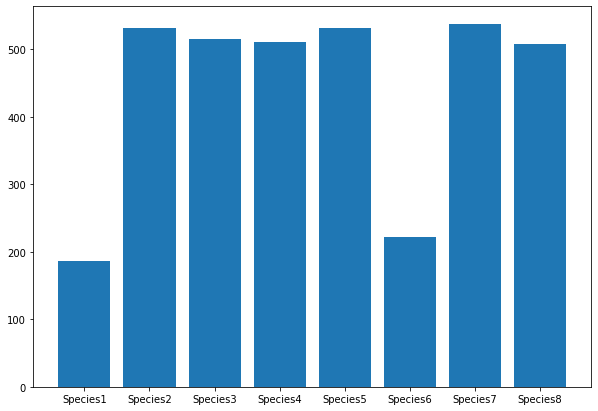

In [13]:
arr = []
nmax = 0
for i in range(8):
  dir_path= "training_data_final/Species{}".format(i+1)
  cont = 0
  for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        cont += 1
  print("Species{}:{}".format(i+1,cont))
  arr.append(cont)
  if nmax < cont: 
    nmax = cont

fig = plt.figure(figsize=(10,7))      
plt.bar(labels, arr)


In [14]:
import shutil
import math   

#class equalizator, we are going to duplicate random files for each species until we reach 
#the maximum number of image of the most populated class -> Species7 with 537 images
for i in range(8):
  dir_path= "training_data_final/Species{}".format(i+1)
  cont = 0
  if arr[i]<nmax:
    random_files = []
    dim = arr[i]
    #ex class 1 has 186 images, (537-186)/186 = 1.8, we must add duplicate 
    #the 186 images + the remaining 165-> 2 cycles (obtained with ceil(.))
    for j in range(math.ceil((nmax-dim)/arr[i])):
      #we random sample the number of files we need
      tmp = random.sample(os.listdir(dir_path),min(nmax-dim,arr[i]))
      dim += len(tmp)
      #we add one by one (probably there is an easier way) 
      for f in tmp:
        random_files.append('{}_'.format(j+1)+f)
    #we copy the files in the folder with a prefix
    for file in random_files:
      shutil.copy2(dir_path+'/'+file[2:], dir_path+'/'+"Duplicated{}".format(file))
  for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        cont += 1
  print("Species{}:{}".format(i+1,cont))
  arr.append(cont)
  if nmax < cont: 
    nmax = cont

Species1:537
Species2:537
Species3:537
Species4:537
Species5:537
Species6:537
Species7:537
Species8:537


In [15]:
arr = []
nmax = 0
for i in range(8):
  dir_path= "training_data_final/Species{}".format(i+1)
  cont = 0
  for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        cont += 1
  print("Species{}:{}".format(i+1,cont))
  arr.append(cont)
  if nmax < cont: 
    nmax = cont

Species1:537
Species2:537
Species3:537
Species4:537
Species5:537
Species6:537
Species7:537
Species8:537


In [16]:
!pip install split-folders
import splitfolders
splitfolders.ratio('training_data_final', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 4296 files [00:01, 3842.17 files/s]


In [17]:
# Dataset folders 
dataset_dir = 'output'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

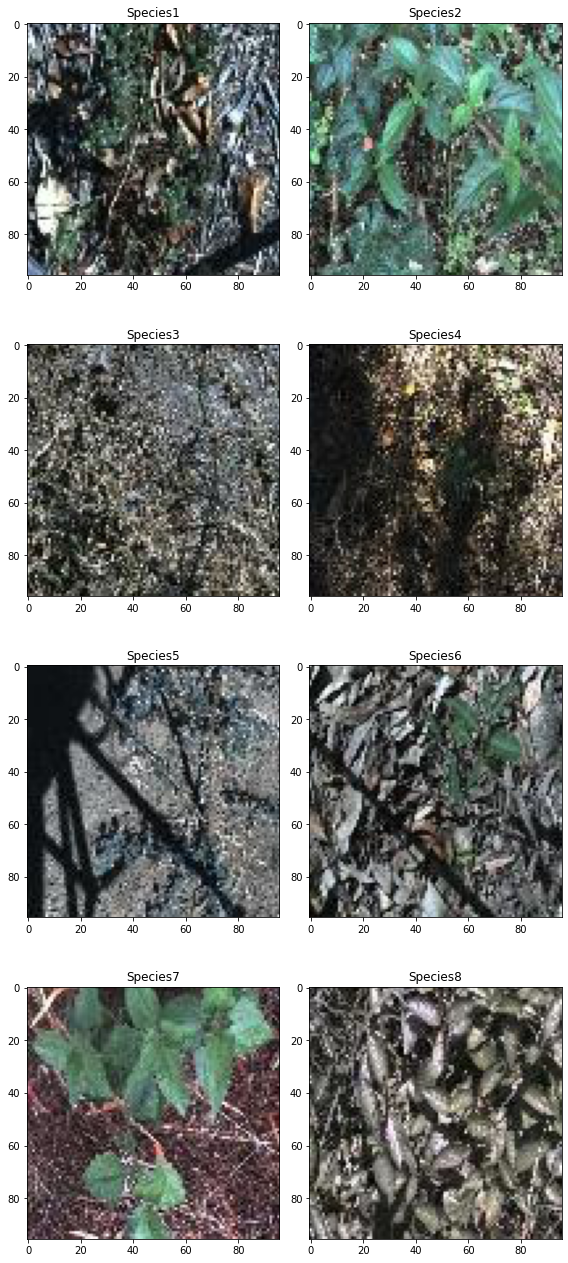

In [18]:
# Plot example images from dataset
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8' #7
      ]        

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [19]:
#preprocessing_function =tf.keras.applications.efficientnet_v2.preprocess_input
batch_size = 32

In [20]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=60,
                                        height_shift_range=40,
                                        width_shift_range=40,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode = 'reflect',
                                        brightness_range = [0.7,1.3],                                   
                                        channel_shift_range = 35,
                                        #preprocessing_function = preprocessing_function
                                        #preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input,
                                        #preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                        #preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                        #rescale=1/255. # rescale value is multiplied to the image
                                        )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed
                                                       )

Found 3432 images belonging to 8 classes.


In [21]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

# Create an instance of ImageDataGenerator for training, validation, and test sets
valid_data_gen = ImageDataGenerator(
          #rescale=1/255.
          #preprocessing_function = preprocessing_function
          #preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input,
          #preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
          #preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
          )
test_data_gen = ImageDataGenerator(
          #rescale=1/255.
          #preprocessing_function = preprocessing_function
          #preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input,
          #preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
          #preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
          )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False,
                                              seed=seed)

Found 424 images belonging to 8 classes.
Found 440 images belonging to 8 classes.


In [22]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  # image = image[0]
  # target = target[0]
  # target_idx = np.argmax(target)
  # print()
  # print("Categorical label:", target)
  # print("Label:", target_idx)
  # print("Class name:", labels[target_idx])
  # fig = plt.figure(figsize=(6, 4))
  # plt.imshow(np.uint8(image))

  return batch

In [23]:
input_shape = (96, 96, 3)
epochs = 200

In [24]:
# Download and plot the efficientNet model
supernet = tf.keras.applications.convnext.ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
#supernet.summary()

#wo FT:
  # Accuracy: 0.7238
  # Precision: 0.7676
  # Recall: 0.6808
  # F1: 0.6668
#with FT: 
 #N=200
  # Accuracy: 0.7459
  # Precision: 0.7388
  # Recall: 0.7116
  # F1: 0.7033

 #N=150,(equal) PreTrained (no equal)
  # Accuracy: 0.8182
  # Precision: 0.8315
  # Recall: 0.8182
  # F1: 0.8154


785596384/785596384 [==============================] - 7s 0us/step


In [25]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)
x = supernet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

quasi_svm = tfkl.experimental.RandomFourierFeatures(
            output_dim=4096,
            kernel_initializer="gaussian",
            trainable = True
)(x)

x = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(quasi_svm)


# Connect input and output through the Model class
ft_model = tfk.Model(inputs,x, name='model')

# Compile the model
ft_model.compile(loss=tfk.losses.hinge, optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.CategoricalAccuracy(name="acc")])
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 random_fourier_features (Ra  (None, 4096)             6295553   
 ndomFourierFeatures)                                            
                                                                 
 dense (Dense)               (None, 8)                 32776     
                                                                 
Total params: 202,558,665
Trainable params: 32,777
Non-traina

First training with all the layers freezed to compute weights of the SVM

In [26]:
# Freeze first N layers
N = 295
ft_model.get_layer('convnext_large').trainable = True


for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
# for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
#    print(i, layer.name, layer.trainable)
ft_model.summary()
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 random_fourier_features (Ra  (None, 4096)             6295553   
 ndomFourierFeatures)                                            
                                                                 
 dense (Dense)               (None, 8)                 32776     
                                                                 
Total params: 202,558,665
Trainable params: 32,777
Non-traina

In [27]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  # ckpt_dir = os.path.join(exp_dir, 'ckpts')
  # if not os.path.exists(ckpt_dir):
  #     os.makedirs(ckpt_dir)

  # ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
  #                                                    save_weights_only=True, # True to save only weights
  #                                                    save_best_only=False) # True to save only the best epoch 
  # callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [28]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN')

# Train the model
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
108/108 [==============================] - 102s 705ms/step - loss: 1.2893 - accuracy: 0.5306 - val_loss: 0.9873 - val_accuracy: 0.6415
Epoch 2/200
108/108 [==============================] - 62s 575ms/step - loss: 0.8843 - accuracy: 0.6874 - val_loss: 0.7802 - val_accuracy: 0.7170
Epoch 3/200
108/108 [==============================] - 61s 563ms/step - loss: 0.7973 - accuracy: 0.7072 - val_loss: 0.7701 - val_accuracy: 0.6958
Epoch 4/200
108/108 [==============================] - 65s 599ms/step - loss: 0.7384 - accuracy: 0.7343 - val_loss: 0.8121 - val_accuracy: 0.7311
Epoch 5/200
108/108 [==============================] - 62s 575ms/step - loss: 0.7514 - accuracy: 0.7334 - val_loss: 0.6440 - val_accuracy: 0.7618
Epoch 6/200
108/108 [==============================] - 63s 584ms/step - loss: 0.7018 - accuracy: 0.7558 - val_loss: 0.6727 - val_accuracy: 0.7807
Epoch 7/200
108/108 [==============================] - 62s 571ms/step - loss: 0.6715 - accuracy: 0.7628 - val_loss: 0.7284 

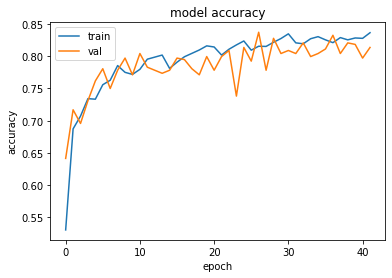

In [29]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

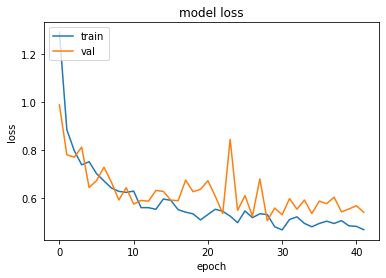

In [30]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Second training with only N layers freezed to tune the model

In [31]:
# Freeze first N layers
N = 200
ft_model.get_layer('convnext_large').trainable = True

for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
# for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
#    print(i, layer.name, layer.trainable)
ft_model.summary()
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 random_fourier_features (Ra  (None, 4096)             6295553   
 ndomFourierFeatures)                                            
                                                                 
 dense (Dense)               (None, 8)                 32776     
                                                                 
Total params: 202,558,665
Trainable params: 102,113,801
Non-t

In [32]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN')

# Train the model
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
108/108 [==============================] - 102s 754ms/step - loss: 0.4278 - accuracy: 0.8421 - val_loss: 0.4938 - val_accuracy: 0.8325
Epoch 2/200
108/108 [==============================] - 77s 714ms/step - loss: 0.4236 - accuracy: 0.8499 - val_loss: 0.4748 - val_accuracy: 0.8467
Epoch 3/200
108/108 [==============================] - 74s 684ms/step - loss: 0.4166 - accuracy: 0.8520 - val_loss: 0.4607 - val_accuracy: 0.8467
Epoch 4/200
108/108 [==============================] - 77s 713ms/step - loss: 0.3981 - accuracy: 0.8578 - val_loss: 0.4431 - val_accuracy: 0.8514
Epoch 5/200
108/108 [==============================] - 75s 692ms/step - loss: 0.3713 - accuracy: 0.8636 - val_loss: 0.4574 - val_accuracy: 0.8467
Epoch 6/200
108/108 [==============================] - 75s 695ms/step - loss: 0.3584 - accuracy: 0.8762 - val_loss: 0.4475 - val_accuracy: 0.8491
Epoch 7/200
108/108 [==============================] - 74s 685ms/step - loss: 0.3846 - accuracy: 0.8680 - val_loss: 0.4444 

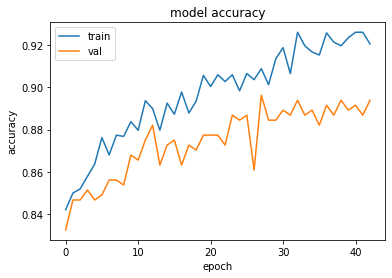

In [33]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

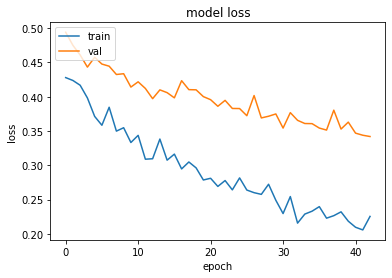

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Save the best model and test it

In [35]:
# Save best epoch model
ft_model.save("drive/MyDrive/ANNDL1/models")

In [36]:
model = tfk.models.load_model('drive/MyDrive/ANNDL1/models')

14/14 [==============================] - 10s 401ms/step
Accuracy: 0.8705
Precision: 0.8694
Recall: 0.8705
F1: 0.8683


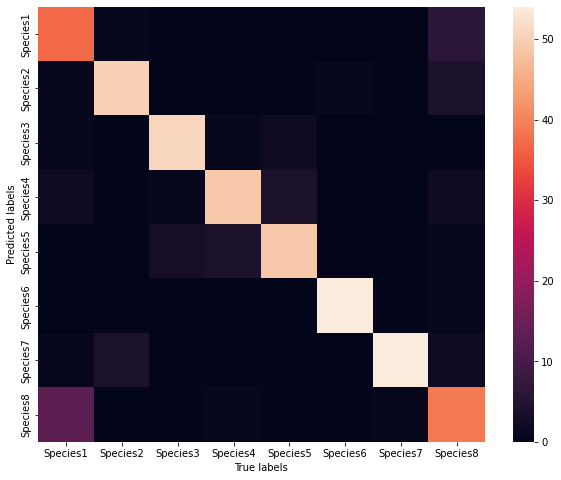

In [37]:
y_test = test_gen.labels
predictions = ft_model.predict(test_gen)
# Compute the confusion matrix
cm = confusion_matrix(y_test, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=-1))
precision = precision_score(y_test, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_test, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_test, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()